# Relationship between P-values and False Positives

In [1]:
import functools
import itertools
from matplotlib import pyplot as plt 
from matplotlib import collections as mc
import numpy
import scipy
import seaborn

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
seaborn.set(font_scale=2.5)
seaborn.set_style("whitegrid")

### User Defined Inputs

In [4]:
reps_ = 1000000
n_ = 100

mean_ = 2.
stddev_ = 1.3

alpha_ = 0.05

### 5% are False Positives

The 2-sample t-test determines whether or not a statistically significant difference exists between two population means. That is, do the two samples come from different distributions (i.e. populations)? If two samples are drawn from the same distribution, it is reasonably assumed that the t-test would never suggest a difference between the two means, but the test sometimes does. This is because of the threshold that determines statistical significance. If we want 95% confidence, what we are really saying is we will except that 5% of the time a statistical difference will be detected where none exists.

In [5]:
def run_samples_and_test(n, evar, mean, stddev):
    """
    Inputs:
        n (integer): number of data points to sample
        evar (boolean): whether of not the variances of the samples are equal
        mean (double): mean of the distribution from which to sample
        stddev (double): standard deviation of the distribution from which to sample
        
    Output:
        p_val (double): the p-value returned from the t-test
    """
    # run t-test on two samples from the same distribution
    t_stat, p_val = scipy.stats.ttest_ind(
        a=numpy.random.normal(mean, stddev, n), 
        b=numpy.random.normal(mean, stddev, n), 
        equal_var=evar
    )
    
    # return the p-value from the test
    return p_val

def create_sig_ind(p_val, alpha):
    """
    Inputs:
        p_val (double): the p-value returned from run_samples_and_test
        alpha (double): the significance threshold
    
    Output:
        output (integer): 
            0 or 1 depending on whether the p-value meets the significance threshold
    """
    # checking whether or not p-value meets significance threshold
    if p_val <= alpha:
        output = 1
    else:
        output = 0
    
    # output significance indicator
    return output

In [6]:
list_p_values = [
    run_samples_and_test(n=n_, evar=True, mean=mean_, stddev=stddev_) 
    for _ in range(reps_)
]

list_sig_ind = list(map(functools.partial(create_sig_ind, alpha=alpha_), list_p_values))

In [7]:
proportion_false_positive = [
    sum(list_sig_ind[i:i + 100]) / 100 
    for i in range(0, len(list_sig_ind), 100)
]
print(
    "Number of false positive aggregation measurements: {}"
    .format(len(proportion_false_positive))
)

Number of false positive aggregation measurements: 10000


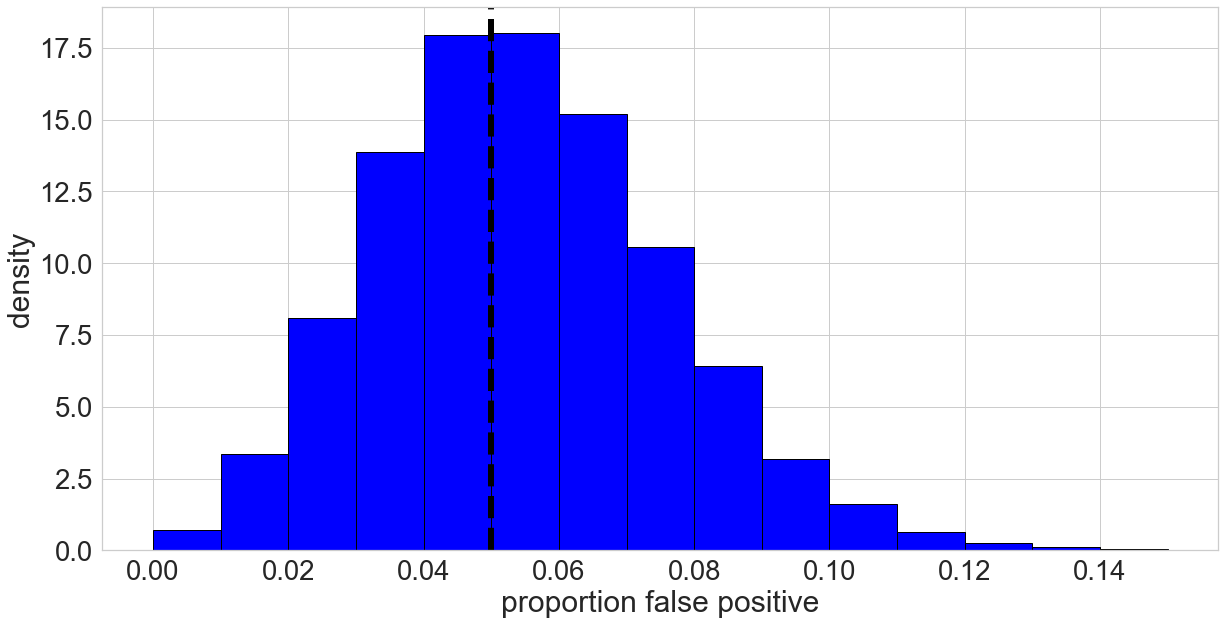

In [8]:
plt.hist(proportion_false_positive, density=True, bins=15, color='blue', edgecolor='black')
plt.axvline(x=alpha_, linestyle='dashed', linewidth=6, color='black')
plt.xlabel('proportion false positive')
plt.ylabel('density')
plt.show()

In [9]:
print(
    "Number of p-values: {}"
    .format(len(list_p_values))
)

Number of p-values: 1000000


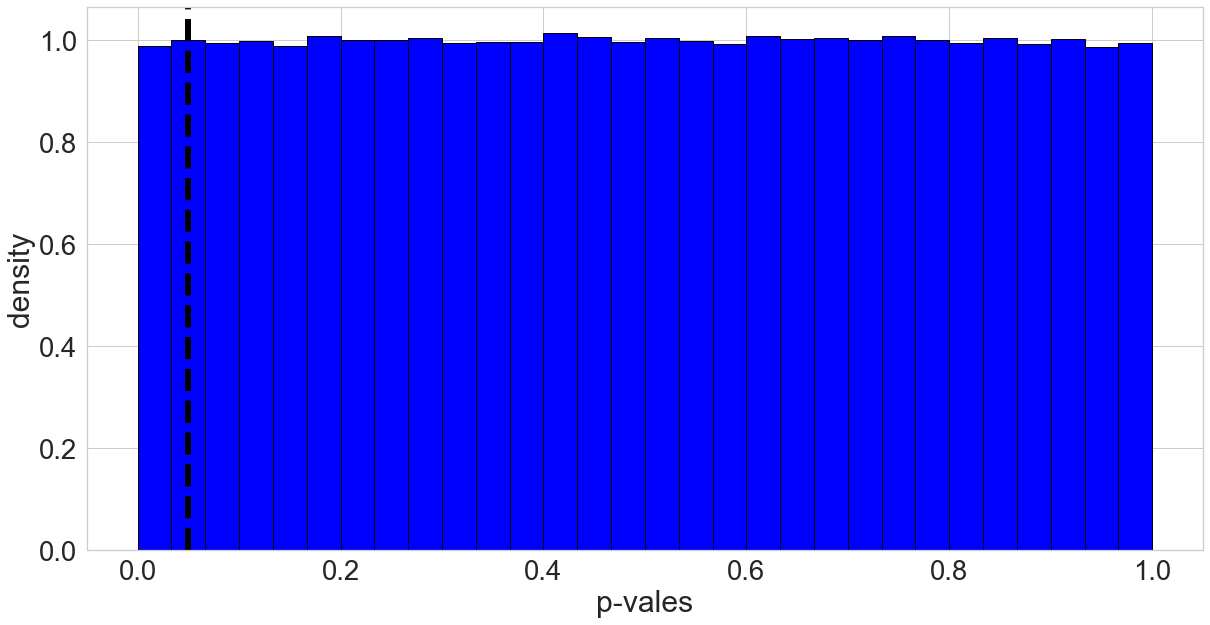

In [10]:
plt.hist(list_p_values, density=True, bins=30, color='blue', edgecolor='black')
plt.axvline(x=alpha_, linestyle='dashed', linewidth=6, color='black')
plt.xlabel('p-vales')
plt.ylabel('density')
plt.show(block=True)

### A Look at the False Positives using Confidence Intervals

In [11]:
def build_confidence_intervals(n, mean, stddev, alpha):
    """
    Inputs:
        n (integer): number of data points to sample
        mean (double): mean of the distribution from which to sample
        stddev (double): standard deviation of the distribution from which to sample
        alpha (double): the significance threshold
    
    Output:
        bounds (tuple): the lower and upper bounds of confidence interval
    """
    # z_star for the confidence interval computation
    z_star = scipy.stats.norm.ppf( ( (1 - alpha) + 1 ) / 2 )
    
    # create a sample and compute the sample mean
    samp = numpy.random.normal(mean, stddev, n)
    samp_mean = numpy.mean(samp)
    
    # calculate lower and upper bounds
    lower_bound = samp_mean - ( z_star * stddev / numpy.sqrt(n) )
    upper_bound = samp_mean + ( z_star * stddev / numpy.sqrt(n) )
    
    # return lower and upper bounds as tuple
    bounds = (lower_bound, upper_bound)
    return bounds

In [12]:
list_intervals = [
    build_confidence_intervals(n=n_, mean=mean_, stddev=stddev_, alpha=alpha_)
    for _ in range(n_)
]

In [13]:
list_intervals_plot = []
list_colors = []

for idx, (lower_, upper_) in enumerate(list_intervals):
    list_intervals_plot.append([(idx, lower_), (idx, upper_)])
    list_colors.append("red" if mean_ < lower_ or mean_ > upper_ else "blue")

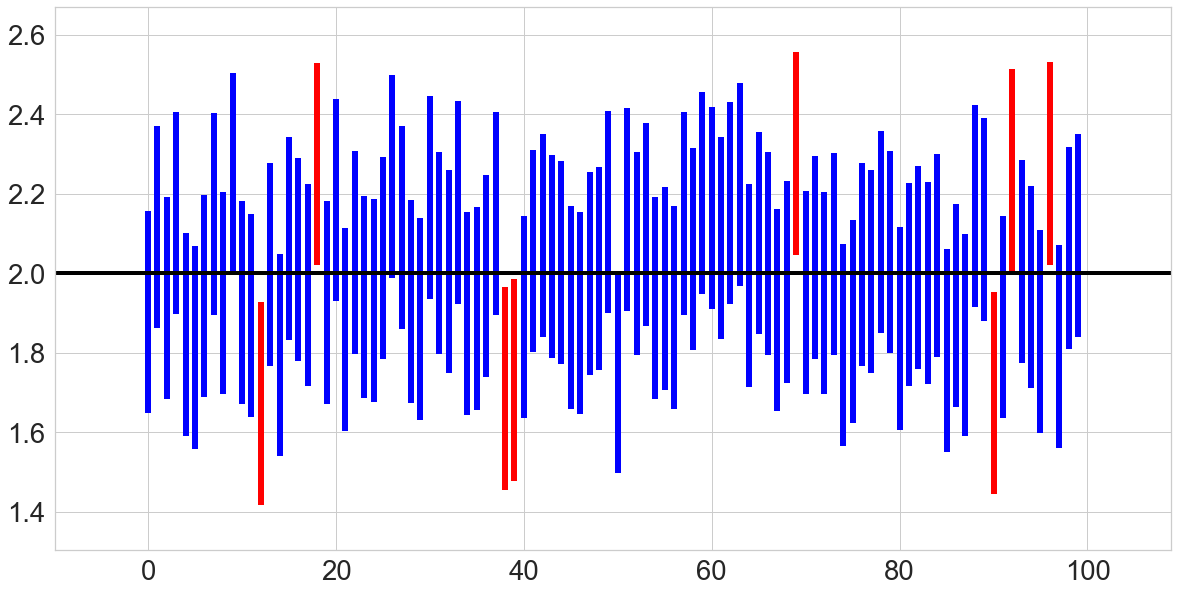

In [14]:
# - black line is the population mean
# - blue line segments are the confidence intervals containing the population mean
# - red line segments are the confidence intervals that do not 
#     contain the population mean... the false positives (in this run 8 out of 100)

fig, ax = plt.subplots()
ax.add_collection(
    mc.LineCollection(list_intervals_plot, colors=list_colors, linewidths=6)
)
ax.axhline(y=mean_, color="black", linewidth=4)
ax.autoscale()
ax.margins(0.1)